In [1]:
import librosa
import numpy as np
import cv2
import glob

In [ ]:
# load .wav and generate CQT-Spectrum, then save as .npy (直接存矩陣不存圖，就沒有resolution的問題)
def store_cqt_npy(fname):
    y, sr = librosa.load('Audio_Data/new_data/'+fname)
    n_bins=84
    CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=sr, n_bins=n_bins)), ref=np.max)
    CQT = cv2.resize(CQT.astype('float'), (60, n_bins), interpolation = cv2.INTER_CUBIC)
    np.save('en_cqt_npy/'+fname, CQT)

filename = glob.glob(r'Audio_Data/new_data/*.wav')
for i in range(len(filename)):
    # mac
    # filename[i] = filename[i].split('/')[1]
    # window
    filename[i] = filename[i].split('\\')[1]
    store_cqt_npy(filename[i])    

In [ ]:
def store_cqt_npy(fname):
    y, sr = librosa.load('Audio_Data/spoken_numbers_pcm/'+fname)
    n_bins=84
    CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=sr, n_bins=n_bins)), ref=np.max)
    CQT = cv2.resize(CQT.astype('float'), (60, n_bins), interpolation = cv2.INTER_CUBIC)
    np.save('en_cqt_npy/'+fname, CQT)
filename = glob.glob(r'Audio_Data/spoken_numbers_pcm/*.wav')
for i in range(len(filename)):
    filename[i] = filename[i].split('\\')[1]
    store_cqt_npy(filename[i])  

In [ ]:
# save CQT-Spectrum image
from librosa import display
filename_npy = glob.glob(r'en_cqt_npy/*.npy')
for i in range(len(filename_npy)):
    a = np.load(filename_npy[i])
    filename_npy[i] = filename_npy[i].split('\\')[1]
    librosa.display.specshow(a, y_axis='linear');
    plt.axis('off')
    plt.savefig('EN_CQT_Spectrum/'+filename_npy[i]+'.png')

In [2]:
#%% 讀取npy，總共2880筆
import random
from keras.utils import np_utils
x_list = []
y_list = []
filename_npy = glob.glob(r'en_cqt_npy/*.npy')
# 洗牌一下，到時只要切最後一塊出來當test就好，比較方便不用用抽樣的
random.shuffle(filename_npy)
for i in range(len(filename_npy)):
    x_list.append(np.load(filename_npy[i]))
    # mac
    # y_list.append(filename_npy[i].split('/')[1][0])
    # window
    y_list.append(filename_npy[i].split('\\')[1][0])

Using TensorFlow backend.


In [3]:
len(x_list)

2880

In [4]:
# 2500做train、380做test
div = 2500
x_train = np.asarray(x_list[:div])
y_train = np.asarray(y_list[:div])
x_test = np.asarray(x_list[div:])
y_test = np.asarray(y_list[div:])
x_train = x_train.reshape(-1,84,60,1)
x_test = x_test.reshape(-1,84,60,1)

print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())

# normalized和1-hot
x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

4.55258726653 -87.7311910676
3.01361772651 -84.9515907109


In [5]:
#%% 測試一下GPU是不是available
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#%% import package
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import SGD
from keras.datasets import mnist
from keras import optimizers
from keras.layers.advanced_activations import LeakyReLU

In [6]:
tf.test.is_gpu_available()

True

In [7]:
#%% model
model = Sequential()

input_shape = (84, 60, 1)

model.add(Conv2D(16, (7, 7), padding='same', input_shape=input_shape))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, (5, 5), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.0005),
              loss='kullback_leibler_divergence',
              metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 84, 60, 16)        800       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 84, 60, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 30, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 30, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 30, 32)        12832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 42, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 15, 32)        0         
__________

In [9]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping('val_acc', patience=5, verbose=1)

In [10]:
#%% fit model
model_history = model.fit(x_train, y_train, batch_size=128, epochs=100,
                          validation_data = (x_test, y_test),
                          shuffle = True,
                          callbacks=[early_stopping]
                         )

Train on 2500 samples, validate on 380 samples
Epoch 1/100
2500/2500 [==============================] - 5s 2ms/step - loss: 2.8675 - acc: 0.1636 - val_loss: 2.7744 - val_acc: 0.1658
Epoch 2/100
2500/2500 [==============================] - 1s 519us/step - loss: 2.2033 - acc: 0.2900 - val_loss: 2.6210 - val_acc: 0.2500
Epoch 3/100
2500/2500 [==============================] - 1s 525us/step - loss: 1.7022 - acc: 0.4284 - val_loss: 2.8939 - val_acc: 0.2816
Epoch 4/100
2500/2500 [==============================] - 1s 522us/step - loss: 1.2457 - acc: 0.5580 - val_loss: 2.3688 - val_acc: 0.2895
Epoch 5/100
2500/2500 [==============================] - 1s 522us/step - loss: 0.8883 - acc: 0.6788 - val_loss: 2.1622 - val_acc: 0.3105
Epoch 6/100
2500/2500 [==============================] - 1s 520us/step - loss: 0.5963 - acc: 0.7952 - val_loss: 1.3127 - val_acc: 0.5237
Epoch 7/100
2500/2500 [==============================] - 1s 525us/step - loss: 0.4113 - acc: 0.8576 - val_loss: 1.2285 - val_acc: 0.6

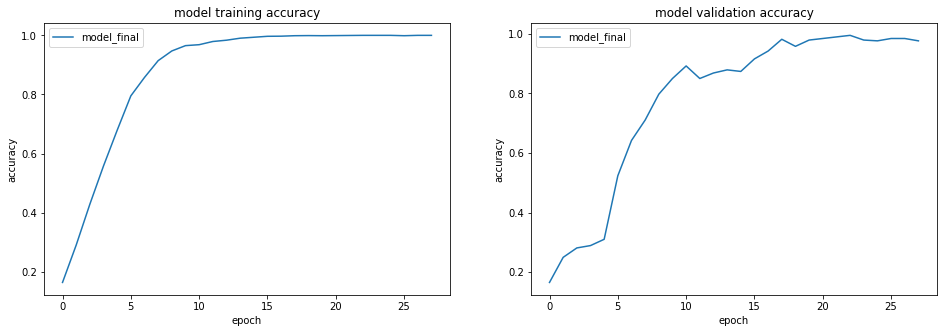

In [11]:
# 作圖
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,2,1)
plt.plot(model_history.history["acc"])

plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

ax2 = fig.add_subplot(1,2,2)
plt.plot(model_history.history["val_acc"])

plt.title("model validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

plt.show()

In [12]:
# score
score = model.evaluate(x_test, y_test, batch_size=10000)
print("Loss: %f" %score[0])
print("testing accuracy: %f" %(score[1]*100))

380/380 [==============================] - 0s 1ms/step
Loss: 0.079949
testing accuracy: 97.631580


In [13]:
#%% 儲存model
model.save('EN_CQT_CNN.h5')